In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 16000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)
    print(conv3.shape)
    print(conv4.shape)
    print(conv5.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv5, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)

    # Output, class prediction
    fc2 = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print(fc2.shape)
    return fc2

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 64 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 64])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # 3x4 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # 3x4 conv, 64 inputs, 64 outputs
    'wc4': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc5': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # fully connected, 2*2*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*64, 1024])),
    # 1024 inputs, 14 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([64])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bc4': tf.Variable(tf.random_normal([64])),
    'bc5': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 64)
(?, 3, 4, 64)
(?, 3, 4, 64)
(?, 3, 4, 64)
(?, 2, 2, 64)
(?, 1024)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 68710360.000000, Accuracy = 0.00900000054389
Performance on test set: Training epochs #1000, Batch Loss = 38741860.0, Accuracy = 0.0
Training epochs #20000: Batch Loss = 33661720.000000, Accuracy = 0.0860000029206
Performance on test set: Training epochs #20000, Batch Loss = 38622940.0, Accuracy = 0.0
Training epochs #40000: Batch Loss = 33598380.000000, Accuracy = 0.00700000021607
Performance on test set: Training epochs #40000, Batch Loss = 20453948.0, Accuracy = 0.00400000018999
Training epochs #60000: Batch Loss = 15767537.000000, Accuracy = 0.164999991655
Performance on test set: Training epochs #60000, Batch Loss = 3775352.25, Accuracy = 0.805000007153
Training epochs #80000: Batch Loss = 8350965.500000, Accuracy = 0.493999958038
Performance on test set: Training epochs #80000, Batch Loss = 3665504.5, Accuracy = 0.805000066757
Training epochs #100000: Batch Loss = 25664042.000000, Accuracy = 0.0850000083447
Performance on test set: Training epo

Training epochs #920000: Batch Loss = 1339032.375000, Accuracy = 0.745999991894
Performance on test set: Training epochs #920000, Batch Loss = 233928.59375, Accuracy = 0.942999958992
Training epochs #940000: Batch Loss = 871097.250000, Accuracy = 0.84399998188
Performance on test set: Training epochs #940000, Batch Loss = 347459.5625, Accuracy = 0.942999958992
Training epochs #960000: Batch Loss = 573598.437500, Accuracy = 0.89099997282
Performance on test set: Training epochs #960000, Batch Loss = 411276.375, Accuracy = 0.943000078201
Training epochs #980000: Batch Loss = 6545435.000000, Accuracy = 0.275999993086
Performance on test set: Training epochs #980000, Batch Loss = 208961.84375, Accuracy = 0.949000120163
Training epochs #1000000: Batch Loss = 1100045.125000, Accuracy = 0.740999996662
Performance on test set: Training epochs #1000000, Batch Loss = 216197.3125, Accuracy = 0.949000120163
Training epochs #1020000: Batch Loss = 844299.500000, Accuracy = 0.838999986649
Performance

Training epochs #1820000: Batch Loss = 314558.500000, Accuracy = 0.90600001812
Performance on test set: Training epochs #1820000, Batch Loss = 147407.34375, Accuracy = 0.961000025272
Training epochs #1840000: Batch Loss = 233991.000000, Accuracy = 0.930000066757
Performance on test set: Training epochs #1840000, Batch Loss = 156493.375, Accuracy = 0.960999965668
Training epochs #1860000: Batch Loss = 2865244.500000, Accuracy = 0.429000020027
Performance on test set: Training epochs #1860000, Batch Loss = 67312.09375, Accuracy = 0.961000025272
Training epochs #1880000: Batch Loss = 435341.187500, Accuracy = 0.836000025272
Performance on test set: Training epochs #1880000, Batch Loss = 110256.507812, Accuracy = 0.961000025272
Training epochs #1900000: Batch Loss = 353121.687500, Accuracy = 0.90600001812
Performance on test set: Training epochs #1900000, Batch Loss = 137037.640625, Accuracy = 0.961000025272
Training epochs #1920000: Batch Loss = 204680.796875, Accuracy = 0.924000024796
Pe

Training epochs #2720000: Batch Loss = 93336.156250, Accuracy = 0.956000089645
Performance on test set: Training epochs #2720000, Batch Loss = 71020.859375, Accuracy = 0.960999965668
Training epochs #2740000: Batch Loss = 1254204.125000, Accuracy = 0.583999931812
Performance on test set: Training epochs #2740000, Batch Loss = 35678.9804688, Accuracy = 0.990000128746
Training epochs #2760000: Batch Loss = 163575.671875, Accuracy = 0.921000063419
Performance on test set: Training epochs #2760000, Batch Loss = 66163.0234375, Accuracy = 0.968000054359
Training epochs #2780000: Batch Loss = 163288.984375, Accuracy = 0.93599998951
Performance on test set: Training epochs #2780000, Batch Loss = 73362.84375, Accuracy = 0.961000025272
Training epochs #2800000: Batch Loss = 104956.968750, Accuracy = 0.950000047684
Performance on test set: Training epochs #2800000, Batch Loss = 65320.25, Accuracy = 0.961000025272
Training epochs #2820000: Batch Loss = 1360703.000000, Accuracy = 0.547000050545
Per

Training epochs #3620000: Batch Loss = 759544.187500, Accuracy = 0.645999968052
Performance on test set: Training epochs #3620000, Batch Loss = 23789.9179688, Accuracy = 0.990999996662
Training epochs #3640000: Batch Loss = 118525.945312, Accuracy = 0.946000099182
Performance on test set: Training epochs #3640000, Batch Loss = 29863.375, Accuracy = 0.976000010967
Training epochs #3660000: Batch Loss = 91980.523438, Accuracy = 0.951000034809
Performance on test set: Training epochs #3660000, Batch Loss = 24389.4042969, Accuracy = 0.967999994755
Training epochs #3680000: Batch Loss = 53718.070312, Accuracy = 0.97000002861
Performance on test set: Training epochs #3680000, Batch Loss = 18464.5097656, Accuracy = 0.981999993324
Training epochs #3700000: Batch Loss = 760719.375000, Accuracy = 0.652999997139
Performance on test set: Training epochs #3700000, Batch Loss = 23167.578125, Accuracy = 0.990999937057
Training epochs #3720000: Batch Loss = 86200.593750, Accuracy = 0.945000052452
Perf

Training epochs #4520000: Batch Loss = 52545.472656, Accuracy = 0.964000046253
Performance on test set: Training epochs #4520000, Batch Loss = 9162.51367188, Accuracy = 0.991000056267
Training epochs #4540000: Batch Loss = 35904.726562, Accuracy = 0.972999989986
Performance on test set: Training epochs #4540000, Batch Loss = 4756.7421875, Accuracy = 0.993000030518
Training epochs #4560000: Batch Loss = 19115.726562, Accuracy = 0.982000052929
Performance on test set: Training epochs #4560000, Batch Loss = 4336.49951172, Accuracy = 0.993000030518
Training epochs #4580000: Batch Loss = 417826.000000, Accuracy = 0.731000006199
Performance on test set: Training epochs #4580000, Batch Loss = 14462.3554688, Accuracy = 0.991000056267
Training epochs #4600000: Batch Loss = 33347.171875, Accuracy = 0.976999998093
Performance on test set: Training epochs #4600000, Batch Loss = 7467.02978516, Accuracy = 0.991000056267
Training epochs #4620000: Batch Loss = 37315.609375, Accuracy = 0.975999951363
P

Training epochs #5440000: Batch Loss = 2686.429443, Accuracy = 0.992999970913
Performance on test set: Training epochs #5440000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #5460000: Batch Loss = 283978.312500, Accuracy = 0.783000051975
Performance on test set: Training epochs #5460000, Batch Loss = 8520.55175781, Accuracy = 0.991000056267
Training epochs #5480000: Batch Loss = 12461.136719, Accuracy = 0.981000006199
Performance on test set: Training epochs #5480000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #5500000: Batch Loss = 20177.650391, Accuracy = 0.978000044823
Performance on test set: Training epochs #5500000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #5520000: Batch Loss = 9160.389648, Accuracy = 0.991000056267
Performance on test set: Training epochs #5520000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #5540000: Batch Loss = 308756.843750, Accuracy = 0.773000001907
Performance on test set: Training epochs #554

Training epochs #6380000: Batch Loss = 13398.013672, Accuracy = 0.986000061035
Performance on test set: Training epochs #6380000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6400000: Batch Loss = 5865.428711, Accuracy = 0.987000048161
Performance on test set: Training epochs #6400000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6420000: Batch Loss = 161486.984375, Accuracy = 0.838000059128
Performance on test set: Training epochs #6420000, Batch Loss = 4547.70263672, Accuracy = 0.991000056267
Training epochs #6440000: Batch Loss = 7077.551758, Accuracy = 0.989000022411
Performance on test set: Training epochs #6440000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6460000: Batch Loss = 10714.717773, Accuracy = 0.988000035286
Performance on test set: Training epochs #6460000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6480000: Batch Loss = 4212.840820, Accuracy = 0.995000004768
Performance on test set: Training epochs #64800

Training epochs #7340000: Batch Loss = 4176.648438, Accuracy = 0.996000111103
Performance on test set: Training epochs #7340000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7360000: Batch Loss = 676.314514, Accuracy = 0.998000025749
Performance on test set: Training epochs #7360000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7380000: Batch Loss = 72877.578125, Accuracy = 0.887000083923
Performance on test set: Training epochs #7380000, Batch Loss = 483.831756592, Accuracy = 0.996999979019
Training epochs #7400000: Batch Loss = 3155.093994, Accuracy = 0.995000064373
Performance on test set: Training epochs #7400000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7420000: Batch Loss = 4377.916504, Accuracy = 0.991999983788
Performance on test set: Training epochs #7420000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7440000: Batch Loss = 652.419800, Accuracy = 0.998000025749
Performance on test set: Training epochs #7440000, B

Training epochs #8300000: Batch Loss = 2836.553223, Accuracy = 0.993000030518
Performance on test set: Training epochs #8300000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8320000: Batch Loss = 2804.520996, Accuracy = 0.995000004768
Performance on test set: Training epochs #8320000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8340000: Batch Loss = 54001.675781, Accuracy = 0.913000047207
Performance on test set: Training epochs #8340000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8360000: Batch Loss = 1136.832642, Accuracy = 0.996000051498
Performance on test set: Training epochs #8360000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #8380000: Batch Loss = 4563.133789, Accuracy = 0.991999983788
Performance on test set: Training epochs #8380000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8400000: Batch Loss = 972.467285, Accuracy = 0.998000025749
Performance on test set: Training epochs #8400000, Batch Loss = 0.0, Acc

Training epochs #9260000: Batch Loss = 611.374512, Accuracy = 0.995999932289
Performance on test set: Training epochs #9260000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9280000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #9280000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #9300000: Batch Loss = 39668.289062, Accuracy = 0.925999999046
Performance on test set: Training epochs #9300000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9320000: Batch Loss = 2174.205078, Accuracy = 0.995000064373
Performance on test set: Training epochs #9320000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9340000: Batch Loss = 2301.666992, Accuracy = 0.996000051498
Performance on test set: Training epochs #9340000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9360000: Batch Loss = 380.203247, Accuracy = 0.996999979019
Performance on test set: Training epochs #9360000, Batch Loss = 0.0, Accuracy

Training epochs #10220000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #10220000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10240000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #10240000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #10260000: Batch Loss = 28175.416016, Accuracy = 0.933000028133
Performance on test set: Training epochs #10260000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10280000: Batch Loss = 780.831177, Accuracy = 0.995000064373
Performance on test set: Training epochs #10280000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10300000: Batch Loss = 331.027954, Accuracy = 0.999000072479
Performance on test set: Training epochs #10300000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10320000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #10320000, Batch Loss = 0.0, Accu

Training epochs #11180000: Batch Loss = 392.371033, Accuracy = 0.998000025749
Performance on test set: Training epochs #11180000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11200000: Batch Loss = 71.783630, Accuracy = 0.999000072479
Performance on test set: Training epochs #11200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11220000: Batch Loss = 10023.085938, Accuracy = 0.966000020504
Performance on test set: Training epochs #11220000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11240000: Batch Loss = 512.994141, Accuracy = 0.996999979019
Performance on test set: Training epochs #11240000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11260000: Batch Loss = 1083.466797, Accuracy = 0.996000051498
Performance on test set: Training epochs #11260000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11280000: Batch Loss = 86.129944, Accuracy = 0.999000072479
Performance on test set: Training epochs #11280000, Batc

Training epochs #12140000: Batch Loss = 485.212433, Accuracy = 0.998000025749
Performance on test set: Training epochs #12140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12160000: Batch Loss = 0.000000, Accuracy = 1.0
Performance on test set: Training epochs #12160000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #12180000: Batch Loss = 9865.222656, Accuracy = 0.957000017166
Performance on test set: Training epochs #12180000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #12200000: Batch Loss = 347.008270, Accuracy = 0.996000051498
Performance on test set: Training epochs #12200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12220000: Batch Loss = 1450.610840, Accuracy = 0.996000051498
Performance on test set: Training epochs #12220000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12240000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #12240000, Batch Loss = 0.0, Accuracy = 1.00000011

Training epochs #13120000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #13120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13140000: Batch Loss = 5142.317383, Accuracy = 0.973000049591
Performance on test set: Training epochs #13140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13160000: Batch Loss = 710.208740, Accuracy = 0.997000038624
Performance on test set: Training epochs #13160000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #13180000: Batch Loss = 42.774063, Accuracy = 0.999000072479
Performance on test set: Training epochs #13180000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13200000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #13200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13220000: Batch Loss = 6442.835449, Accuracy = 0.968000054359
Performance on test set: Training epochs #13220000, Batch Loss = 0.0, Ac

Training epochs #14080000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #14080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14100000: Batch Loss = 2998.047363, Accuracy = 0.976999998093
Performance on test set: Training epochs #14100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14120000: Batch Loss = 242.461258, Accuracy = 0.998000085354
Performance on test set: Training epochs #14120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14140000: Batch Loss = 28.742813, Accuracy = 0.999000072479
Performance on test set: Training epochs #14140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14160000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #14160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14180000: Batch Loss = 2354.305908, Accuracy = 0.980999946594
Performance on test set: Training epochs #14180000, Batch Loss

Training epochs #15040000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #15040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15060000: Batch Loss = 1931.066895, Accuracy = 0.986999988556
Performance on test set: Training epochs #15060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15080000: Batch Loss = 137.017441, Accuracy = 0.999000072479
Performance on test set: Training epochs #15080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15100000: Batch Loss = 112.386566, Accuracy = 0.996000051498
Performance on test set: Training epochs #15100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15120000: Batch Loss = 35.956501, Accuracy = 0.999000072479
Performance on test set: Training epochs #15120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15140000: Batch Loss = 2195.257324, Accuracy = 0.98199993372
Performance on test set: Training epochs #15140000, Batch Lo

Training epochs #16000000: Batch Loss = 41.753441, Accuracy = 0.999000072479
Performance on test set: Training epochs #16000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Optimization Finished!


# performance visualization

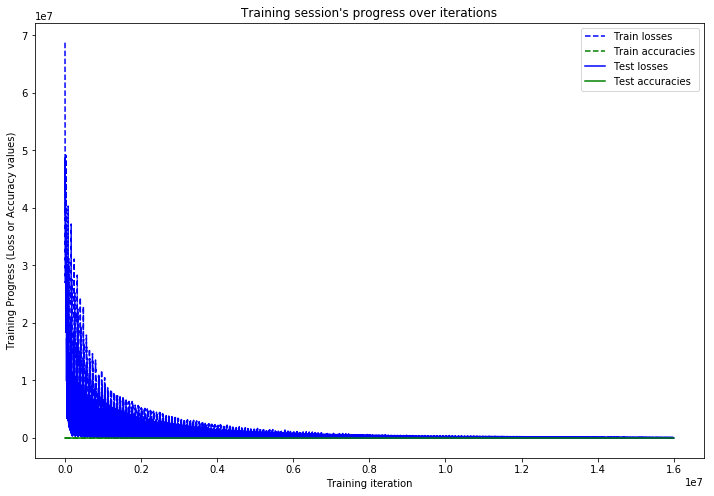

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 98.0179648733%
Recall: 97.995%
f1_score: 97.9898375988%

Confusion Matrix:
[[    0    18     0     0     0     0     0     0     0     0     0     0
      0]
 [    1   780     0     0    32    20     0    50     0    26     0     2
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     6     0     0  2859     0     0    23     0     0     0     3
      0]
 [    0    25     0     0     2   314     0     7     0     0     0     0
      0]
 [    0     7     0     0     0     0 14486     0     0     2     0     0
      0]
 [    0    34     0     0    54    24     1   417     0     5     0     0
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     4     0     0
      0]
 [    0     0     0     0     0     0     0  

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


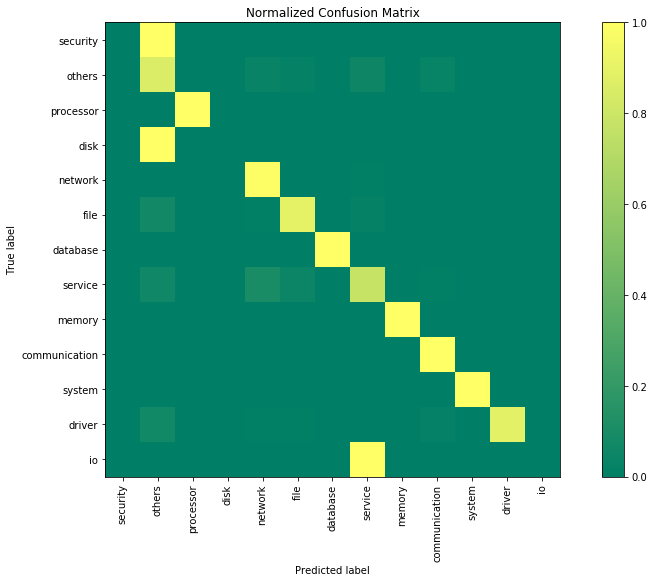

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)